### 1st Virtual Methods Seminar: Methods of Computational Social Science
## Introduction to Social Network Science with Python
# Brokerage and Closure (Demo)
Instructors: Haiko Lietz & Olga Zagovora

Date: September 23, 2020
## Packages

In [1]:
import sys
libs_path = '../libs/'
sys.path.append(libs_path)
import compsoc as cs

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from sklearn.manifold import MDS

## Elite families: Multiplex ties in Renaissance Florence
The information we have about the direction of ties in the elite families graph is not sufficient to allow interpretations in the sense that information flows in the direction of the ties or that ties indicate a hierarchy. The information about the types of tie are also of limited use as most algorithms are neither developed nor implemented for multiplex networks. In the following, we want to understand the differences and similarities of standard measures of brokerge and closure. To keep things simple, we will do this on the **simple (undirected, unweighted, unlayered) graph** of relations among elite families:

In [3]:
families, _, relations, _ = cs.elite_families_collection(path='../../data/elite_families/')

In [4]:
relations_unlayered = cs.weighted_edge_list_to_unlayered(relations)

In [5]:
relations_unlayered_undirected = cs.weighted_edge_list_to_undirected(relations_unlayered)

In [6]:
G = cs.construct_graph(
    directed=False, 
    multiplex=False, 
    graph_name='elite_families_unlayered_undirected', 
    node_list=families, 
    edge_list=relations_unlayered_undirected, 
    node_pos=['pos_x', 'pos_y'], 
    node_color='partisanship_color', 
    node_shape='party_id', 
    node_label='family'
)

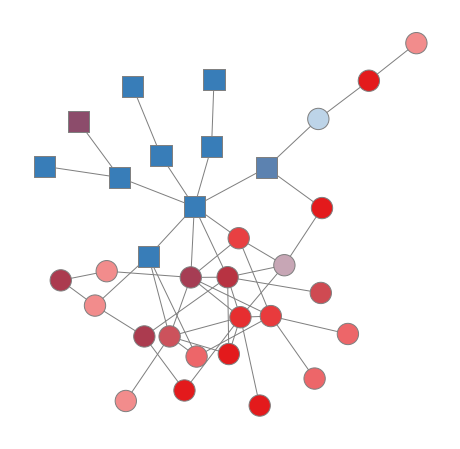

In [7]:
cs.draw_graph(
    G, 
    node_size_factor=.5, 
    edge_width=None, 
    figsize='medium'
)

## Brokerage and Closure
We will now compute standard measures for brokerage and closure. For later analytical purposes, all scores, will be stored in this dataframe:

In [8]:
nodes_scores = pd.DataFrame(index=families['family'])

### Node Centralities
Before we visit the algorithms for brokerage and closure: the number of neighbors of a node determines the extent to which a node can be embedded into an open or closed structure. The larger the degree, the more diverse a neighborhood and the larger a cohesive group can be.

In [9]:
degree = dict(nx.degree(G))

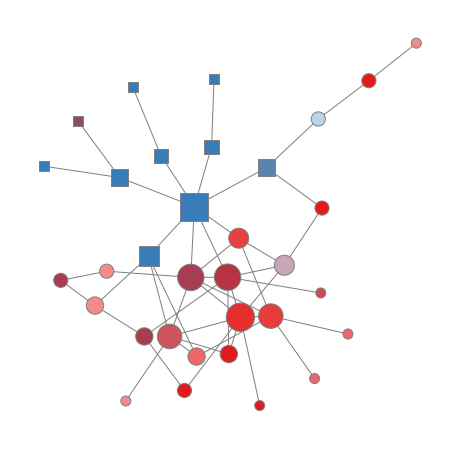

In [10]:
cs.draw_graph(
    G, 
    node_size=degree, 
    node_size_factor=100, 
    edge_width=None, 
    figsize='medium'
)

In [11]:
nodes_scores.loc[:, 'degree'] = list(degree.values())

In [12]:
degree_weighted = dict(nx.degree(G, weight='weight'))

In [13]:
#nodes_scores.loc[:, 'degree_weighted'] = list(degree_weighted.values())

For the purpose of comparing node positional measures, we also compute the other two main centralities. Note that closeness and betweenness are global metrics that take the full graph into account:

In [14]:
closeness = nx.closeness_centrality(G)
betweenness = nx.betweenness_centrality(G)

In [15]:
nodes_scores.loc[:, 'closeness'] = list(closeness.values())
nodes_scores.loc[:, 'betweenness'] = list(betweenness.values())

In [16]:
betweenness_weighted = nx.betweenness_centrality(G, weight='weight')

In [17]:
#nodes_scores.loc[:, 'betweenness_weighted'] = list(betweenness_weighted.values())

### Closure
#### Clustering coefficient
The clustering coefficient $CC(x)$ quantifies the **extent to which potential edges in a node’s neighborhood are realized**. It is a purely local measure, i.e., it only takes the immediate neighborhood of $x$ into account:

In [18]:
clustering = nx.clustering(G)

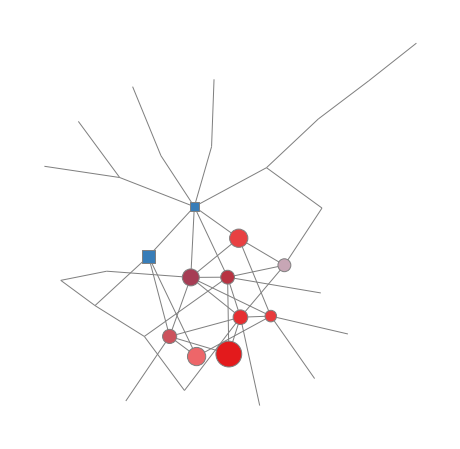

In [19]:
cs.draw_graph(
    G, 
    node_size=clustering, 
    node_size_factor=1000, 
    edge_width=None, 
    figsize='medium'
)

In [20]:
nodes_scores.loc[:, 'clustering'] = list(clustering.values())

In [21]:
clustering_weighted = nx.clustering(G, weight='weight')

In [22]:
#nodes_scores.loc[:, 'clustering_weighted'] = list(clustering_weighted.values())

#### Local efficiency
Node local efficiency $E(x)$ is a generalization of the clustering coefficient. It quantifies the **extent to which neighbors of a node x can reach each other if x was removed**. It is a purely local measure:

In [23]:
def node_local_efficiency(g):
    import itertools
    node_local_efficiency = {}
    for node in g.nodes():
        neighbors = g.adj[node]
        g_neighbors = g.subgraph(neighbors)
        local_efficiency = []
        for edge in itertools.combinations(list(g_neighbors.nodes), 2):
            local_efficiency.append(nx.efficiency(g_neighbors, edge[0], edge[1]))
        sum_local_efficiency = sum(local_efficiency)
        if sum_local_efficiency == 0:
            node_local_efficiency.update({node: 0})
        else:
            len_local_efficiency = len(local_efficiency)
            node_local_efficiency.update({node: sum_local_efficiency/len_local_efficiency})
    return node_local_efficiency

In [24]:
local_efficiency = node_local_efficiency(G)

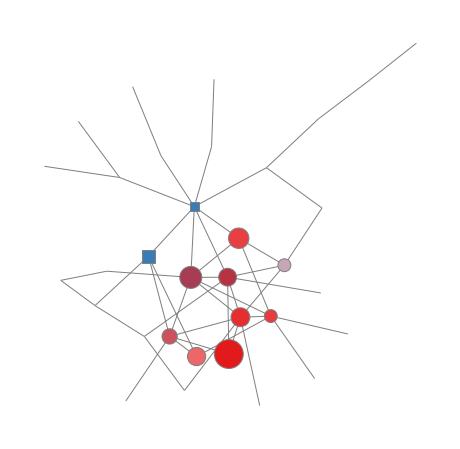

In [25]:
cs.draw_graph(
    G, 
    node_size=local_efficiency, 
    node_size_factor=1000, 
    edge_width=None, 
    figsize='medium'
)

In [26]:
nodes_scores.loc[:, 'local_efficiency'] = list(local_efficiency.values())

### Brokerage
#### Effective size
Effective size $L(x)$ quantifies the **extent to which a node's neighbors are not connected among themselves**. It is also a purely local measure:

In [27]:
effective_size = nx.effective_size(G)

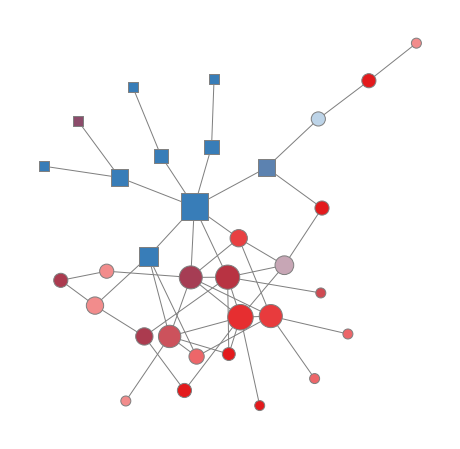

In [28]:
cs.draw_graph(
    G, 
    node_size=effective_size, 
    node_size_factor=100, 
    edge_width=None, 
    figsize='medium'
)

In [29]:
nodes_scores.loc[:, 'effective_size'] = list(effective_size.values())

In [30]:
effective_size_weighted = nx.effective_size(G, weight='weight')

In [31]:
#nodes_scores.loc[:, 'effective_size_weighted'] = list(effective_size_weighted.values())

#### Constraint
Constraint $M(x)$ quantifies the **extent to which node x is invested in those neighbors that are themselves invested in the neighbors of x**. It uses the 2-hop environment of $x$:

In [32]:
constraint = nx.constraint(G)

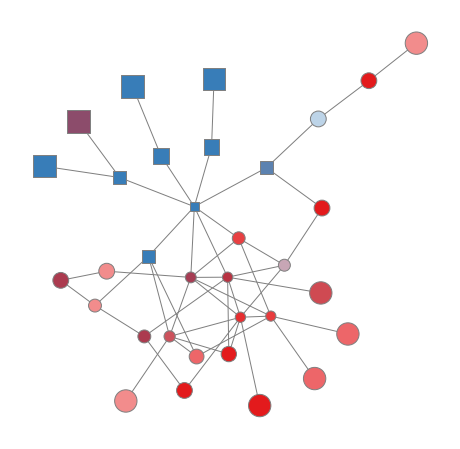

In [33]:
cs.draw_graph(
    G, 
    node_size=constraint, 
    node_size_factor=500, 
    edge_width=None, 
    figsize='medium'
)

In [34]:
nodes_scores.loc[:, 'constraint'] = list(constraint.values())

In [35]:
constraint_weighted = nx.constraint(G, weight='weight')

In [36]:
#nodes_scores.loc[:, 'constraint_weighted'] = list(constraint_weighted.values())

### Mathematical relationship
Latora et al. (2013) found that the clustering coefficient, often measured to operationalize closure, and the effective size, often measured to operationalize brokerage, are two sides of the same coin (cf. lecture):

    effective_size = degree - (degree-1) * clustering

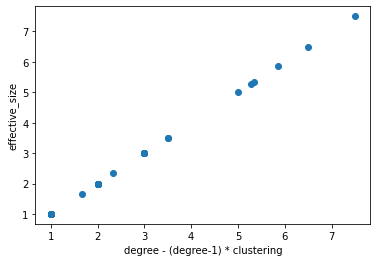

In [37]:
plt.scatter(
    nodes_scores['degree']-(nodes_scores['degree']-1)*nodes_scores['clustering'], 
    nodes_scores['effective_size']
)
plt.xlabel('degree - (degree-1) * clustering')
plt.ylabel('effective_size')
plt.show()

But when the effective size is plotted against the clustering coefficient, there is no obvious correlation:

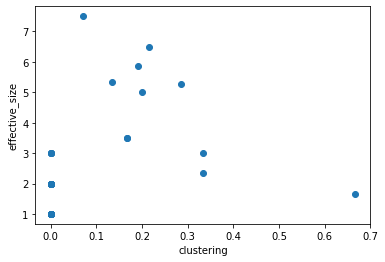

In [38]:
plt.scatter(
    nodes_scores['clustering'], 
    nodes_scores['effective_size']
)
plt.xlabel('clustering')
plt.ylabel('effective_size')
plt.show()

#### Simmelian brokerage
Because of this mathematical relationship, Latora et al. (2013) argue for a new brokerage measure at the interface between the clustering coefficient and effective size. It quantifies the **extent to which a node acts as a broker between otherwise disconnected groops of densely connected nodes**. It is a purely local measure:

In [39]:
def simmelian_brokerage(g, degree=None, local_efficiency=None):
    if degree is None:
        degree = dict(nx.degree(G))
    if local_efficiency is None:
        local_efficiency = node_local_efficiency(G)
    
    return {node: degree[node]-(degree[node]-1)*local_efficiency[node] for node in local_efficiency}

In [40]:
simmelian_brokerage = simmelian_brokerage(G)

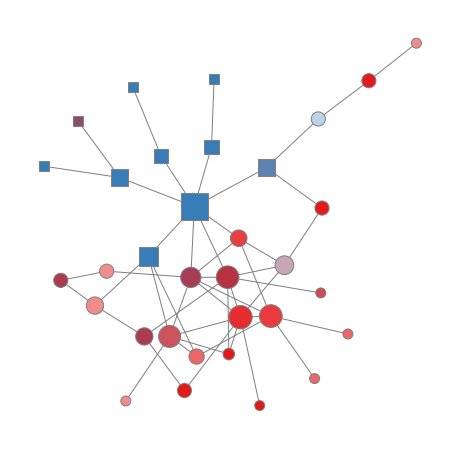

In [41]:
cs.draw_graph(
    G, 
    node_size=simmelian_brokerage, 
    node_size_factor=100, 
    edge_width=None, 
    figsize='medium'
)

In [42]:
nodes_scores.loc[:, 'simmelian_brokerage'] = list(simmelian_brokerage.values())

## Analysis
We have computed standard measures for brokerage and closure:

In [43]:
nodes_scores.head()

,degree,closeness,betweenness,clustering,local_efficiency,effective_size,constraint,simmelian_brokerage
family,,,,,,,,
MEDICI,8,0.492308,0.550691,0.071429,0.089286,7.5,0.149255,7.375
TORNABUONI,3,0.367816,0.196741,0.000000,0.000000,3.0,0.333333,3.000
GUICCIARDINI,4,0.410256,0.111929,0.166667,0.166667,3.5,0.321181,3.500
GINORI,3,0.347826,0.122984,0.000000,0.000000,3.0,0.333333,3.000
DIETISALVI,1,0.260163,0.000000,0.000000,0.000000,1.0,1.000000,1.000


Knowing about the mathematical relationship of clustering coefficient and effective size, we want to see how our measures differ in practice. With pandas, we can easily get the correlation matrix:

In [44]:
nodes_scores.corr()

,degree,closeness,betweenness,clustering,local_efficiency,effective_size,constraint,simmelian_brokerage
degree,1.000000,0.865698,0.760990,0.488359,0.556365,0.984784,-0.808334,0.956583
closeness,0.865698,1.000000,0.724961,0.515219,0.557017,0.848102,-0.786406,0.830299
betweenness,0.760990,0.724961,1.000000,0.121437,0.173932,0.816799,-0.603096,0.833282
clustering,0.488359,0.515219,0.121437,1.000000,0.983082,0.350542,-0.422112,0.292470
local_efficiency,0.556365,0.557017,0.173932,0.983082,1.000000,0.415195,-0.440145,0.338791
effective_size,0.984784,0.848102,0.816799,0.350542,0.415195,1.000000,-0.820560,0.990067
constraint,-0.808334,-0.786406,-0.603096,-0.422112,-0.440145,-0.820560,1.000000,-0.829828
simmelian_brokerage,0.956583,0.830299,0.833282,0.292470,0.338791,0.990067,-0.829828,1.000000


Correlations are only negative when the constraint measure is involved. Unlike all other brokerage metrics, it is not a measure of "opportunity". Since constraint is properly normalized, we can subtract it from 1 to arrive at such a more comparable brokerage measure:

In [45]:
nodes_scores['constraint'] = 1-nodes_scores['constraint']

In [46]:
#nodes_scores['constraint_weighted'] = 1-nodes_scores['constraint_weighted']

We want to insights about which metrics produce similar results. Therefore, we use multidimensional scaling (MDS) to embed our data into a two-dimensional space. The algorithm of the sklearn package needs as input a dissimilarity matrix. The standard way to precompute dissimilarities from correlations is to subtract the latter from 1:

In [47]:
data = (1-nodes_scores.corr()).values

Now reduce dimensionality:

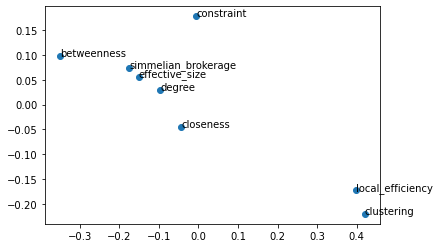

In [48]:
mds = MDS(n_components=2, random_state=3, dissimilarity='precomputed')
pos = mds.fit(data).embedding_
plt.scatter(pos[:, 0], pos[:, 1])
for i in range(0, len(nodes_scores.columns)):
    plt.text(pos[i, 0], pos[i, 1], nodes_scores.columns[i])

We see that clustering coefficient and its generalization, local efficiency, represent one group of metrics. From the literature we know that, in the limits of large data, these measures are inversely related to degree ([Ravasz & Barabási, 2003](https://doi.org/10.1103/PhysRevE.67.026112)). The other group consists of metrics that are more strongly correlated with degree (either positively or negatively, like constraint). Simmelian brokerage is strongly correlated with effective size. While the latter is mathematically related to the clustering coefficient, it is mathematically related to local efficiency. All these metrics are local ones. Constraint is constructed on a node's 2-hop environment. Due to this difference it is a viable alternative to quantifying brokerage opportunities. Betweenness is a global measure. The same is true for the global measure of betweenness centrality. Closeness, also a global measure, is somehow similar to all metrics and should not be used to measure brokerage or closure.